In [11]:
## DESCRIPTION
# lapse rate for the precipitation parameter G

In [12]:
import sys

lib_dir = "/home/daniele/documents/github/ftt01/phd/share/lib"
sys.path.insert( 0, lib_dir )

In [13]:
from lib import *

In [14]:
import logging

In [15]:
def evaluateParameterG( z_i, z_mean, p_i, p_mean ):
    return 1000 / ( z_i - z_mean ) * ( (p_i / p_mean) - 1 )

def evaluateParameterGfromSlope( p_mean, slope ):
    p_mean_plus1000 = p_mean + slope * 1000
    return (p_mean_plus1000 - p_mean) / p_mean

In [16]:
def scatter_plot_interpolated(basin, model, precipitation_df, output_path, logging):

    diff_p = list( precipitation_df['precipitation'] )
    elevation = list( precipitation_df['elevation'] )

    fig, axs = instantiatePlot( "Precipitation $[mm/year]$","Elevation $[m]$" )

    axs.scatter( diff_p, elevation, s=10 ) 
    # axs.set_xlim([min(diff_p)-100,max(diff_p)+100])
    # axs.set_ylim([0,max(elevation)+50])
    axs.set_xlim([500,2000])
    axs.set_ylim([0,4000])

    axs.set_xticks([500,750,1000,1250,1500,1750])
    axs.set_yticks([0,500,1000,1500,2000,2500,3000,3500,4000])

    z1 = np.polyfit( diff_p, elevation, 1 )
    p1 = np.poly1d(z1)

    cc_p  =  np.corrcoef(diff_p, elevation)
    # logging.info( model + " correlation: " + str(cc_p[0][1]) )
    axs.plot( elevation, p1(elevation), "r--" )

    cc_p  =  np.corrcoef(diff_p, elevation)

    output_file_hd = output_path + 'meteo_' + model + '_' + basin + '_precipitation_over_elevation_hd.' + output_format

    mkNestedDir(getPathFromFilepath(output_file_hd))
    fig.savefig( output_file_hd, format=output_format, bbox_inches='tight', facecolor='w', dpi=600 )

    ## evaluation of parameter G
    z_mean=precipitation_df['elevation'].mean()
    # logging.info( basin + " mean elevation: " + str(z_mean) )
    p_mean=precipitation_df['precipitation'].mean()
    # logging.info( basin + " mean precipitation: " + str(p_mean) )

    param_g = evaluateParameterGfromSlope( p_mean, p1[1] )

    # logging.info( basin + " linear regression slope: " + str(p1[1]) )
    # logging.info( basin + " evaluated G: " + str(param_g) )

In [17]:
wdir = "/home/daniele/documents/github/ftt01/phd/projects/era5_evaluation/"
output_path = "/media/windows/projects/era5_bias/01_preprocessing/"

In [18]:
## SETUP
basin = 'AltoAdige'
output_path = output_path + "meteo/" + basin + "/precipitation/over_elevation/"
mkNestedDir(output_path)
output_log = '''{output_path}/{model}_precipitation_lapse_rate_new.log'''

start_date_str = "2010-01-01T00:00:00"
end_date_str = "2019-12-31T23:00:00"
start_date = dt.datetime.strptime( start_date_str, '%Y-%m-%dT%H:%M:%S' )
end_date = dt.datetime.strptime( end_date_str, '%Y-%m-%dT%H:%M:%S' )
dates = pd.date_range(start_date, end_date, freq='h')

/tmp/ipykernel_89051/558223390.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precipitation_df = precipitation_df.append({'id':str(id), 'elevation':df_elev[int(id)], \
/tmp/ipykernel_89051/558223390.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precipitation_df = precipitation_df.append({'id':str(id), 'elevation':df_elev[int(id)], \
/tmp/ipykernel_89051/558223390.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precipitation_df = precipitation_df.append({'id':str(id), 'elevation':df_elev[int(id)], \
/tmp/ipykernel_89051/558223390.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precipitation_df = precipitation_df.ap

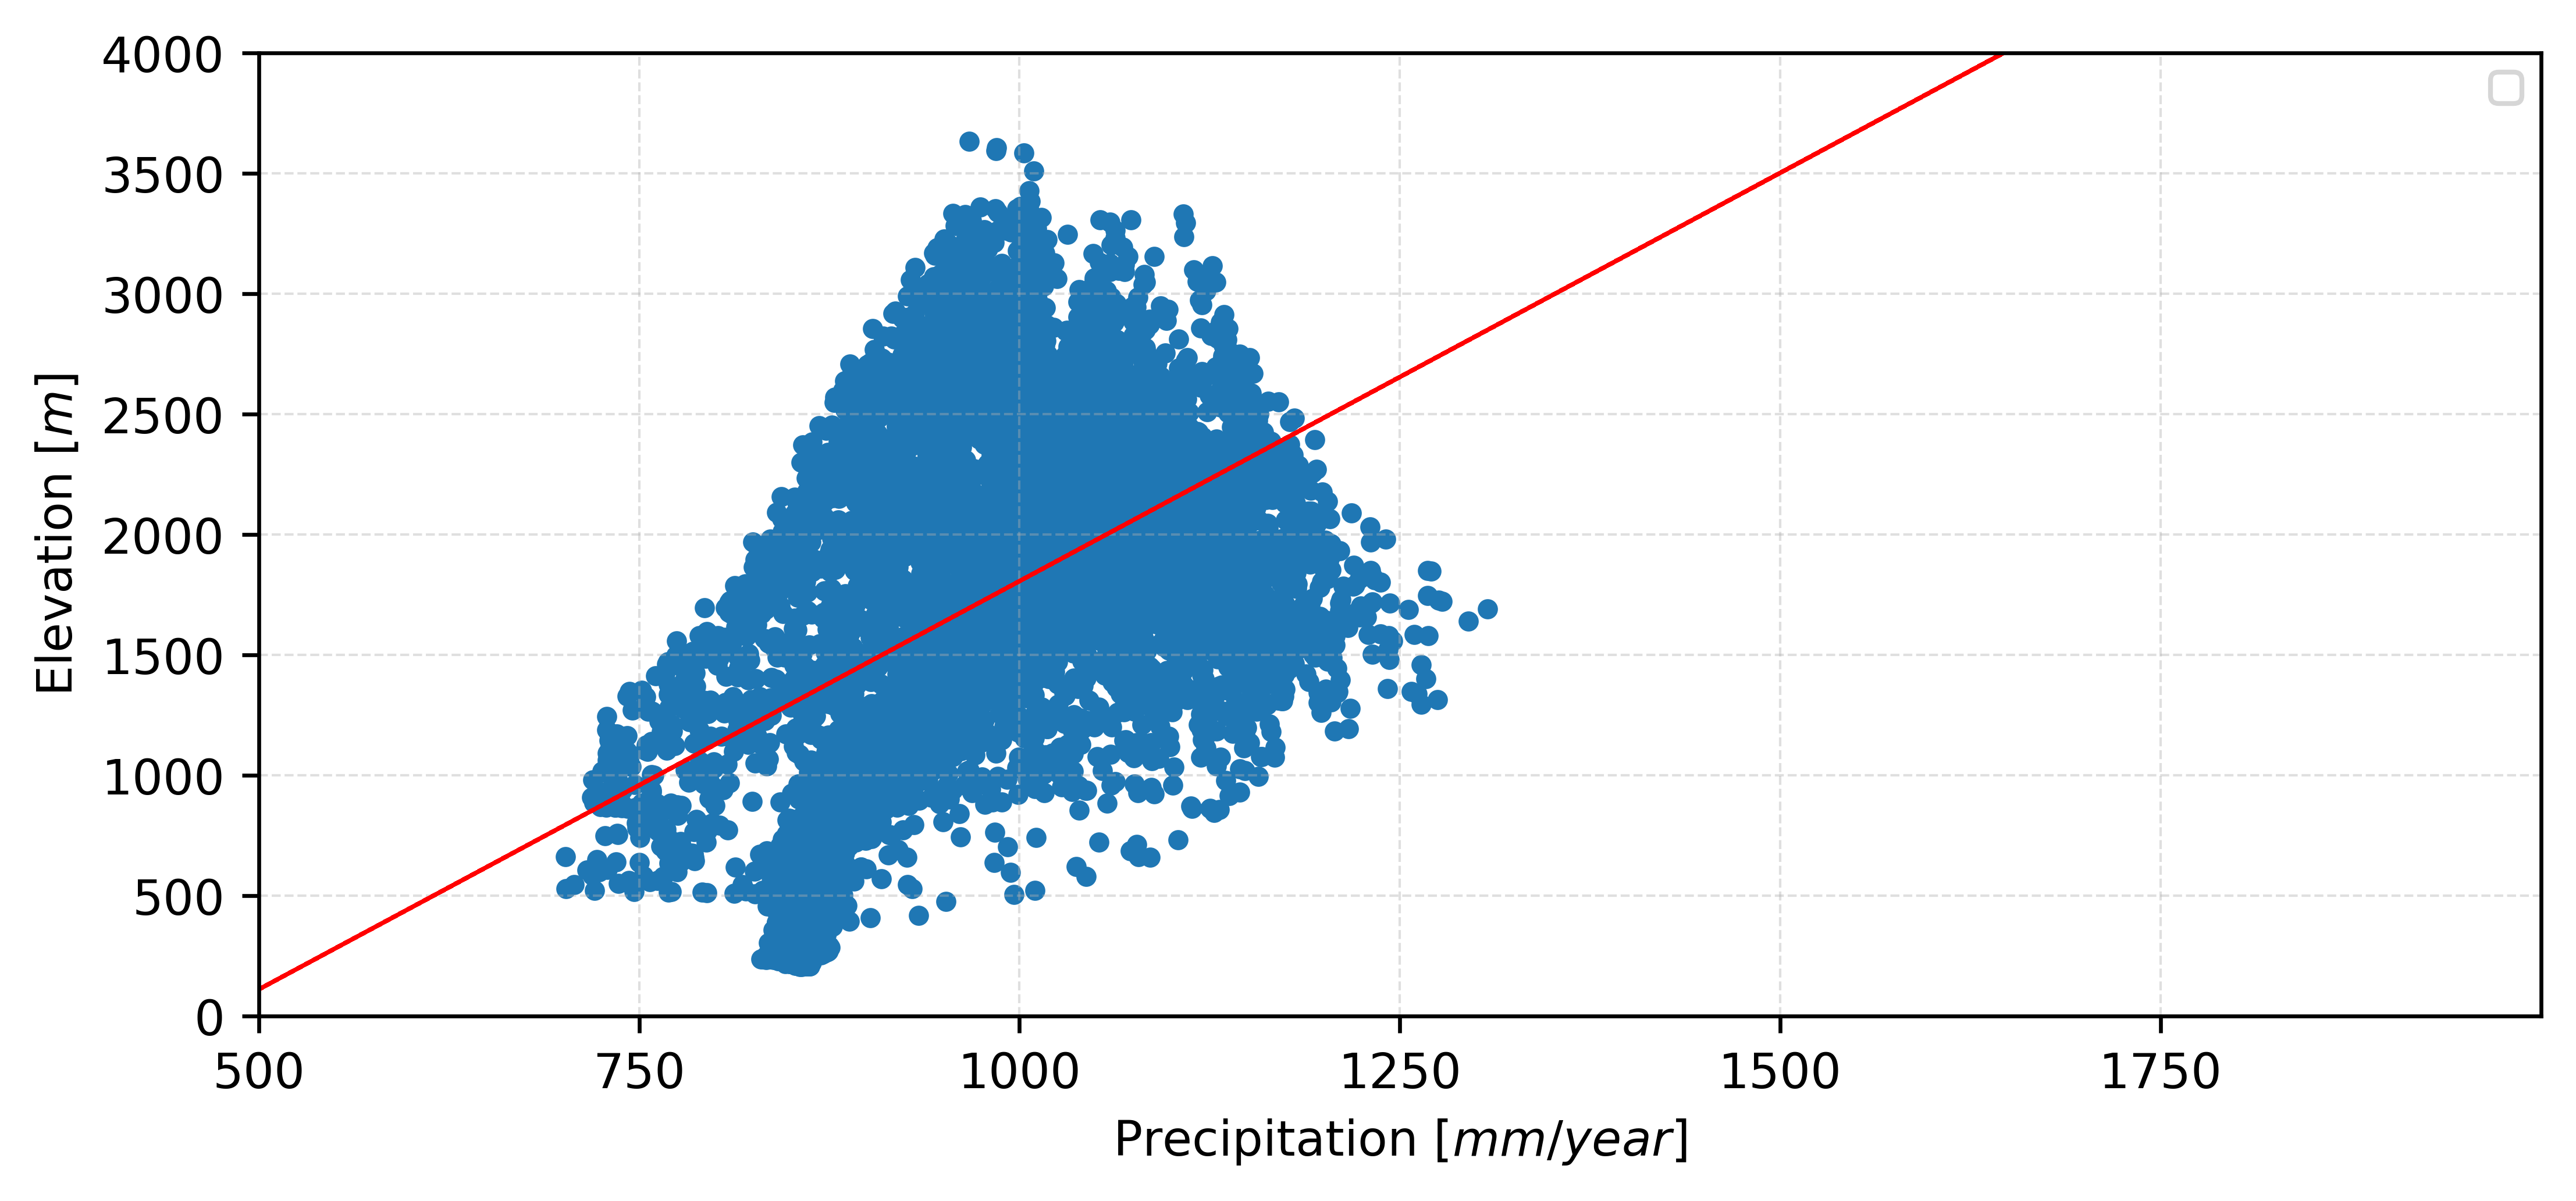

In [19]:
### KR1x1
model = 'KR1x1'
kriging_precipitation_file = "/media/windows/projects/era5_bias/kriging/old/kriging/AltoAdige/P_AltoAdige.krig"
grid_metadata = "/media/windows/projects/era5_bias/kriging/old/grid_1x1km_Adige_river.csv"

# Reading kriging grid metadata - all Adige river cells
df_grid = pd.read_csv( grid_metadata, index_col=0 )
df_elev = df_grid['Elevation']

# df_T = pd.DataFrame(index=dates,columns=['Tinter','Tslope'])
# df_P = pd.DataFrame(index=dates,columns=IDsubbs)

### data entire Alto Adige
df_p = pd.read_csv( kriging_precipitation_file, parse_dates=True, index_col=0 )
df_p['dates'] = dates
df_p.set_index( 'dates',inplace=True )

krig_p = df_p

precipitation_yearly_mean = df_p.resample('Y').sum()

precipitation_yearly_mean_mean = precipitation_yearly_mean.mean()

precipitation_df = pd.DataFrame(columns=['id', 'elevation', 'precipitation'])
for id in precipitation_yearly_mean_mean.index:
    if df_elev[int(id)] != -999:
            # if prec > 400:
        precipitation_df = precipitation_df.append({'id':str(id), 'elevation':df_elev[int(id)], \
            'precipitation': precipitation_yearly_mean_mean[str(id)]}, ignore_index=True)
precipitation_df = precipitation_df.set_index('id')

## PLOT and G
kr1x1_logging = logging.basicConfig(
    filename=output_path+model+".log",
    format='%(asctime)s - %(message)s', level=logging.INFO)

scatter_plot_interpolated(basin, model, precipitation_df, output_path, kr1x1_logging)

In [20]:
### KR11x8
model = 'KR11x8'
path_in = "/media/windows/projects/era5_bias/kriging/old/kriging/AltoAdige/P/"
cells_data = glob.glob( path_in + '*.csv')

i = 0
precipitation = pd.DataFrame() # dataframe kriging with all data in the directory
df_elev = pd.DataFrame(columns=['id', 'elevation'])
for file in cells_data:
    col = file.removeprefix(path_in).strip('.csv')
    # if int(col) in list(ids_in['id']):
    curr_id = int( pd.read_csv( file, index_col=0, header=None ).loc['ID'] )
    curr_elev = int( pd.read_csv( file, index_col=0, header=None ).loc['z'] )
    data_tot = pd.read_csv( file, index_col=0, parse_dates=True, skiprows=4, names=[col] )
    data_tot = data_tot[start_date:end_date]

    df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
    precipitation = pd.concat([precipitation,data_tot],axis=1)
    i = i + 1

df_elev.set_index('id', inplace=True)

precipitation_yearly_mean = precipitation.resample('Y').sum()
precipitation_yearly_mean_mean = precipitation_yearly_mean.mean()

precipitation_df = pd.DataFrame(columns=['id', 'elevation', 'precipitation'])
for id in precipitation_yearly_mean_mean.index:
    e = df_elev.loc[int(id),'elevation']
    if e != -999:
        precipitation_df = precipitation_df.append({'id':str(id), 'elevation':float(e), \
            'precipitation': float(precipitation_yearly_mean_mean[str(id)])}, ignore_index=True)
precipitation_df = precipitation_df.set_index('id')

## PLOT and G
kr11x8_logging = logging.basicConfig(
    filename=output_path+model+".log", 
    format='%(asctime)s - %(message)s', level=logging.INFO)

scatter_plot_interpolated(basin, model, precipitation_df, output_path, kr11x8_logging)

/tmp/ipykernel_89051/985555200.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
/tmp/ipykernel_89051/985555200.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
/tmp/ipykernel_89051/985555200.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
/tmp/ipykernel_89051/985555200.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevation':

/tmp/ipykernel_89051/1331266700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
/tmp/ipykernel_89051/1331266700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
/tmp/ipykernel_89051/1331266700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
/tmp/ipykernel_89051/1331266700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_elev = df_elev.append({'id': curr_id, 'elevati

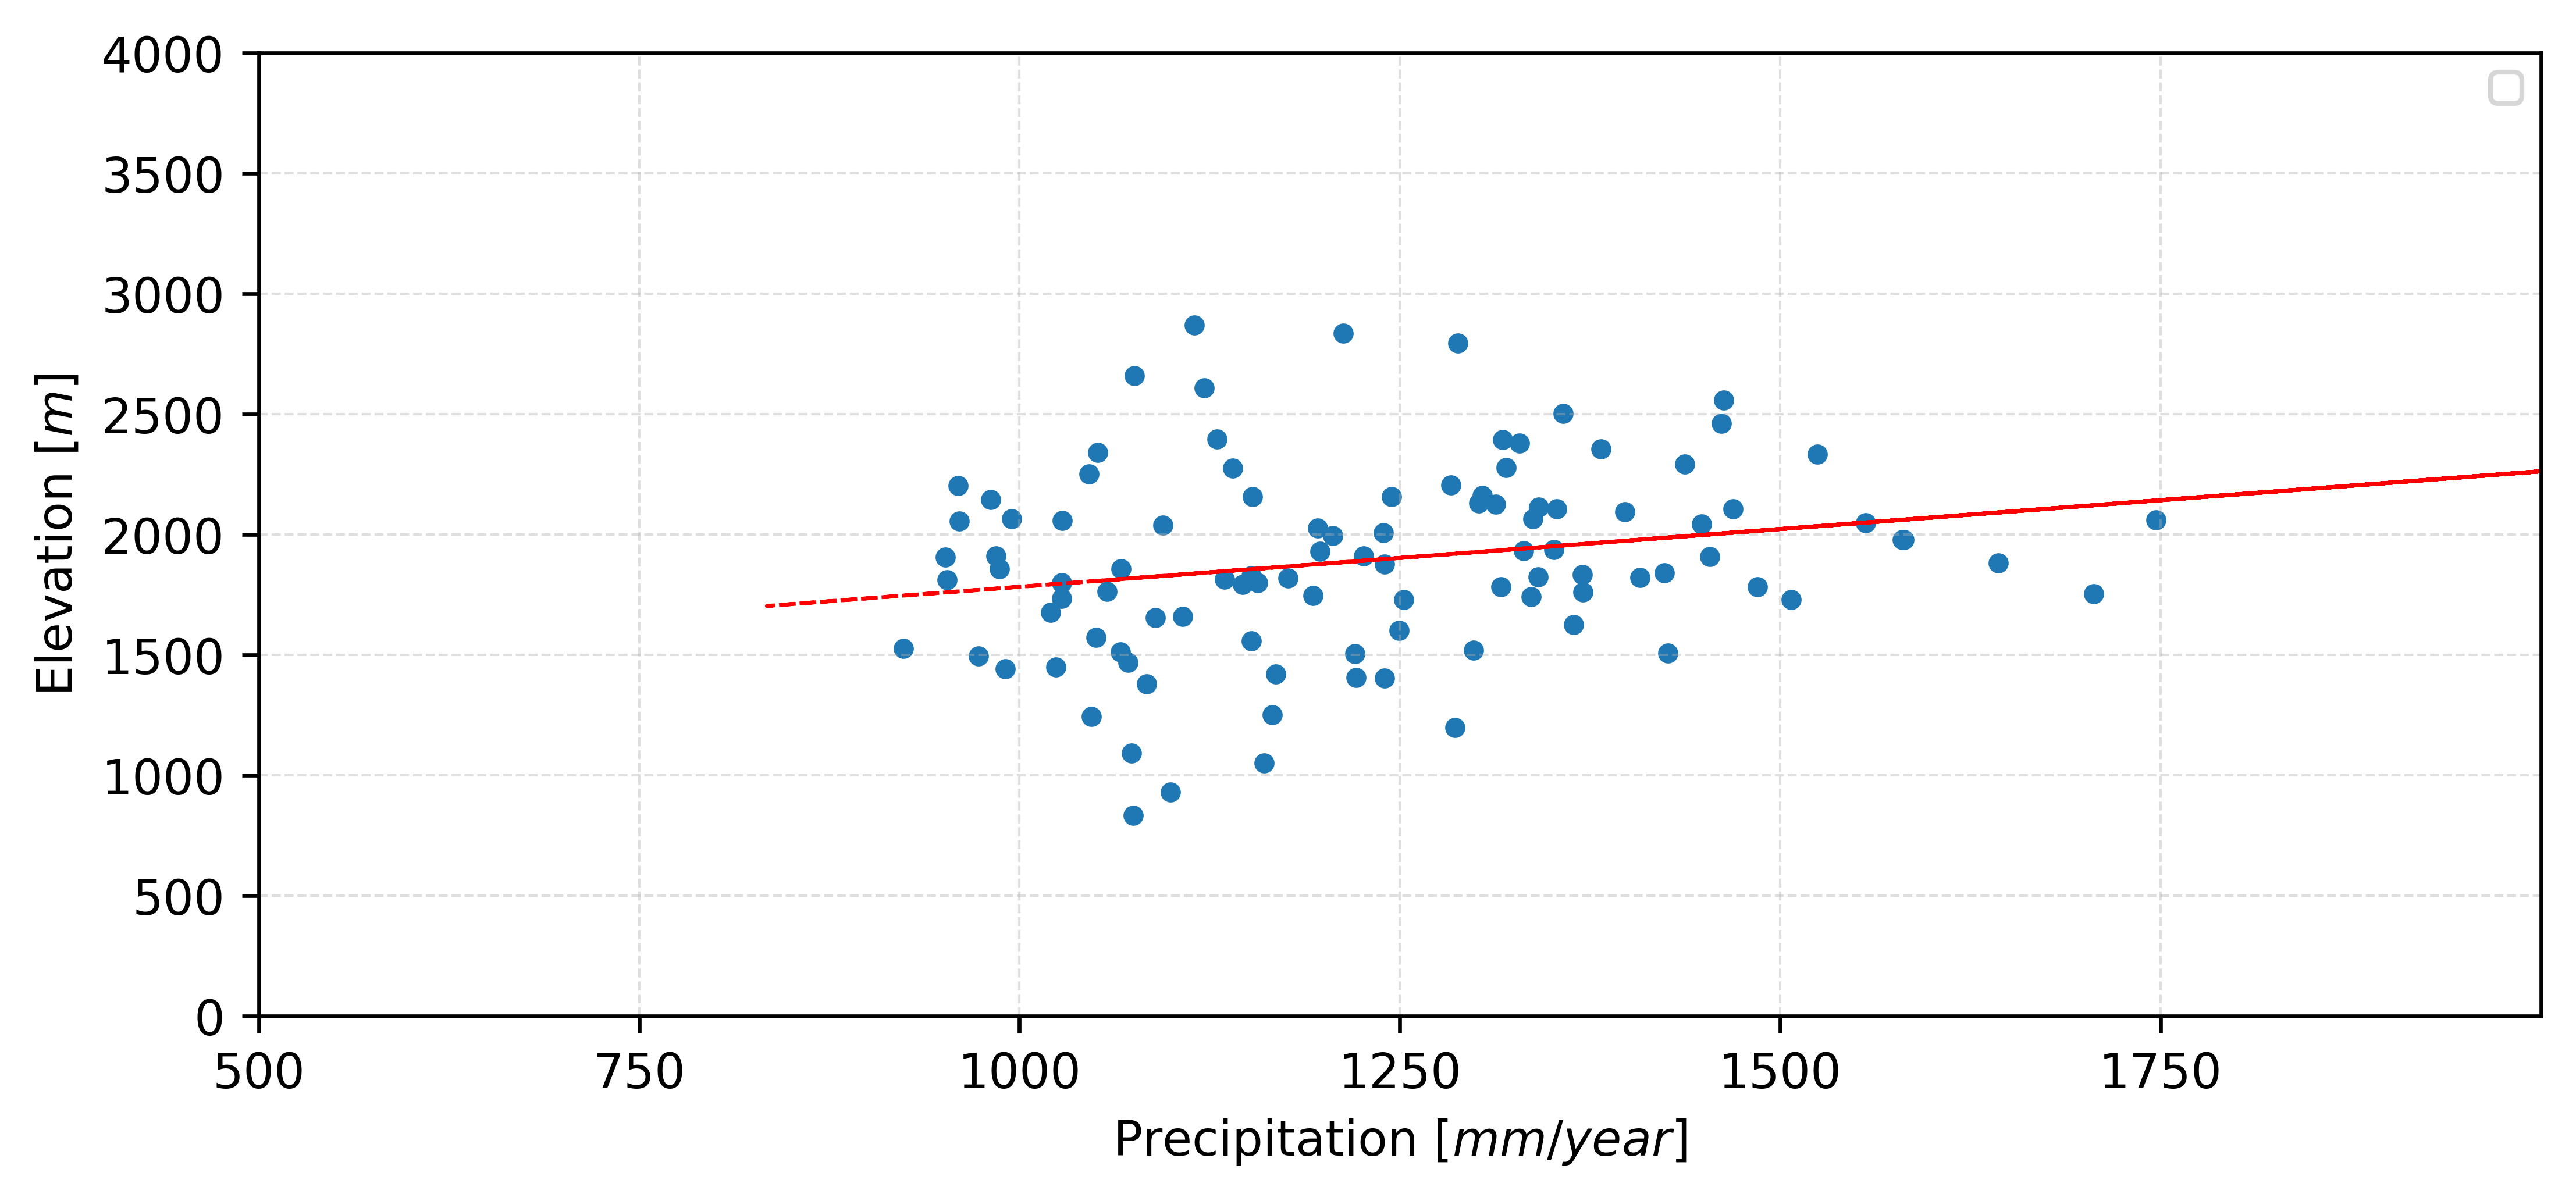

In [21]:
### REA11x8
model = 'REA11x8'
path_in = "/media/windows/projects/era5_bias/OLD/comparison/data/ecmwf/ptot/hourly_ts/"
cells_data = glob.glob( path_in + '*.csv')

i = 0
precipitation = pd.DataFrame() # dataframe kriging with all data in the directory
df_elev = pd.DataFrame(columns=['id', 'elevation'])
for file in cells_data:
    col = file.removeprefix(path_in).strip('.csv')
    # if int(col) in list(ids_in['id']):
    curr_id = int( pd.read_csv( file, index_col=0, header=None ).loc['ID'] )
    curr_elev = int( pd.read_csv( file, index_col=0, header=None ).loc['z'] )
    data_tot = pd.read_csv( file, index_col=0, parse_dates=True, skiprows=4, names=[col] )
    data_tot = data_tot[start_date:end_date]

    df_elev = df_elev.append({'id': curr_id, 'elevation': curr_elev}, ignore_index=True)
    precipitation = pd.concat([precipitation,data_tot],axis=1)
    i = i + 1
   

df_elev.set_index('id', inplace=True)

precipitation_yearly_mean = precipitation.resample('Y').sum()
precipitation_yearly_mean_mean = precipitation_yearly_mean.mean()

precipitation_df = pd.DataFrame(columns=['id', 'elevation', 'precipitation'])
for id in precipitation_yearly_mean_mean.index:
    e = df_elev.loc[int(id),'elevation']
    if e != -999:
        precipitation_df = precipitation_df.append({'id':str(id), 'elevation':float(e), \
            'precipitation': float(precipitation_yearly_mean_mean[str(id)])}, ignore_index=True)
precipitation_df = precipitation_df.set_index('id')

## PLOT and G
rea11x8_logging = logging.basicConfig(
    filename=output_path+model+".log", 
    format='%(asctime)s - %(message)s', level=logging.INFO)

scatter_plot_interpolated(basin, model, precipitation_df, output_path, rea11x8_logging)

In [22]:
path_in_rea = "/media/windows/projects/era5_bias/OLD/comparison/data/ecmwf/ptot/hourly_ts/"
path_in_kr = "/media/windows/projects/era5_bias/kriging/old/kriging/AltoAdige/P/"

In [23]:
points_rea = glob.glob(path_in_rea + '*.csv')

In [24]:
points_kr = glob.glob(path_in_kr + '*.csv')

In [25]:
df_rea = pd.DataFrame(columns=['id','east','north','elev'])

for i in range(len(points_rea)):
    with open(points_rea[i]) as ff:
        lines = ff.readlines()
        id = int(lines[0].split(',')[1][:-3])
        east = float(lines[1].split(',')[1][:-1])
        north = float(lines[2].split(',')[1][:-1])
        elev = float(lines[3].split(',')[1][:-1])

        df_rea.loc[i,'id'] = id
        df_rea.loc[i,'east'] = east
        df_rea.loc[i,'north'] = north
        df_rea.loc[i,'elev'] = elev

        ff.close()

In [26]:
df_kr = pd.DataFrame(columns=['id','east','north','elev'])

for i in range(len(points_kr)):
    with open(points_kr[i]) as ff:
        lines = ff.readlines()
        id = int(lines[0].split(',')[1][:-3])
        east = float(lines[1].split(',')[1][:-1])
        north = float(lines[2].split(',')[1][:-1])
        elev = float(lines[3].split(',')[1][:-1])

        df_kr.loc[i,'id'] = id
        df_kr.loc[i,'east'] = east
        df_kr.loc[i,'north'] = north
        df_kr.loc[i,'elev'] = elev

        ff.close()

<AxesSubplot:xlabel='east', ylabel='north'>

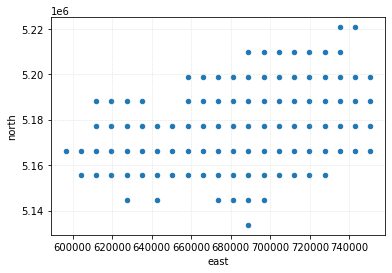

In [27]:
df_rea.plot.scatter(x='east',y='north')

<AxesSubplot:xlabel='east', ylabel='north'>

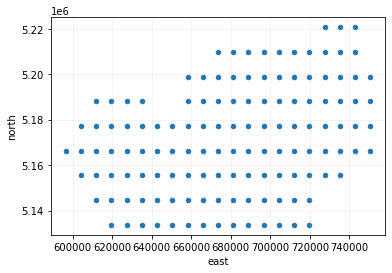

In [28]:
df_kr[df_kr['elev'] != -999.0].plot.scatter(x='east',y='north')